# DATA CLEANING

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import re
import os


In [146]:

facebook_path = "../data/raw/Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Facebook.csv"
instagram_path = "../data/raw/Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Instagram.csv"
linkedin_path = "../data/raw/Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_LinkedIn.csv"
twitter_path = "../data/raw/Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Twitter.csv"

dataframes = {
    "Facebook": pd.read_csv(facebook_path, dtype='object'),
    "Instagram": pd.read_csv(instagram_path, dtype='object'),
    "LinkedIn": pd.read_csv(linkedin_path, dtype='object'),
    "Twitter": pd.read_csv(twitter_path, dtype='object')
}

cleaned_data_dir = "../data/interim"
os.makedirs(cleaned_data_dir, exist_ok=True)

def load_and_clean_data(platform_name, file_path):
    df = pd.read_csv(file_path, dtype='object')
    df.rename(columns={
        "Date": "date",
        "Impressions": "impressions",
        "Engagement Rate (per Impression)": "engagement_rate_per_impression",
        "Engagement Rate (per Reach)": "engagement_rate_per_reach",
        "Engagements": "engagements",
        "Reactions": "reactions",
        "Tags": "tags",
        "Shares": "shares",
        "Likes": "likes",
        "Post": "post",
        "Saves": "saves",
        "Click-Through Rate": "click_through_rate",
        "Post Link Clicks": "post_link_clicks",
        "Other Post Clicks": "other_post_clicks",
        "Post Clicks (All)": "post_clicks_all",
        "Post Hashtag Clicks": "post_hashtag_clicks",
        "Post Detail Expand Clicks": "post_detail_expand_clicks",
        "Profile Clicks": "profile_clicks",
        "Content Type": "content_type",
        "Engaged Users": "engaged_users",
        "Engaged Fans": "subscribers",
        "Network": "network"
    }, inplace=True)
    numeric_columns = [
        "impressions",
        "engagement_rate_per_impression",
        "engagement_rate_per_reach",
        "engagements",
        "reactions",
        "likes",
        "saves",
        "shares",
        "post_link_clicks",
        "click_through_rate",
        "other_post_clicks",
        "post_clicks_all",
        "post_hashtag_clicks",
        "post_detail_expand_clicks",
        "profile_clicks"
    ]
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col].str.replace(',', '').str.replace('%', ''), errors='coerce').fillna(0)
    df['date'] = pd.to_datetime(df['date'], format="%m/%d/%Y %I:%M %p", errors='coerce')
    df['tags'].fillna(' ', inplace=True)
    data_types = {
        "date": "datetime64[ns]",
        "engagement_rate_per_impression": float,
        "engagement_rate_per_reach": float,
        "reactions": int,
        "shares": int,
        "click_through_rate": float,
        "post_link_clicks": int,
        "other_post_clicks": int,
        "tags": str
    }
    df = df.astype(data_types, errors='ignore')
    selected_columns = [
        "date",
        "impressions",
        "engagement_rate_per_impression",
        "engagement_rate_per_reach",
        "engagements",
        "reactions",
        "tags",
        "shares",
        "likes",
        "post",
        "saves",
        "click_through_rate",
        "post_link_clicks",
        "other_post_clicks",
        "post_clicks_all",
        "post_hashtag_clicks",
        "post_detail_expand_clicks",
        "profile_clicks",
        "content_type",
        "engaged_users",
        "subscribers",
        "network"
    ]
    df = df[selected_columns].copy()
    unwanted_columns = [
        "Post ID",
        "Profile",
        "Sent by",
        "Dislikes",
        "Fan Reach",
        "Paid Reach",
        "Linked Content",
        "Fan Impressions",
        "Non-viral Reach",
        "Non-fan Impressions",
        "Fan Paid Impressions",
        "Fan Organic Impressions",
        "Non-fan Paid Impressions",
        "Non-fan Organic Impressions",
        "Post Photo View Clicks",
        "Post Video Play Clicks",
        "Organic Impressions",
        "Viral Impressions",
        "Non-viral Impressions",
        "Paid Impressions",
        "Fan Paid Reach",
        "Post Media Clicks",
        "Love Reactions",
        "Haha Reactions",
        "Wow Reactions",
        "Sad Reactions",
        "Angry Reactions",
        "Potential Reach",
        "Other Engagement Metrics",
        "Post Video Play Clicks"
    ]
    df.drop(columns=unwanted_columns, inplace=True, errors="ignore")
    df.dropna(subset=["impressions", "post"], inplace=True)
    df.sort_values(by="date", inplace=True)
    cleaned_data_file = f"{platform_name}_cleaned.csv"
    cleaned_data_path = os.path.join(cleaned_data_dir, cleaned_data_file)
    if os.path.exists(cleaned_data_path):
        df.to_csv(cleaned_data_path, index=False, mode='w')
    else:
        df.to_csv(cleaned_data_path, index=False)
    return df
facebook_df = load_and_clean_data("Facebook", facebook_path)
instagram_df = load_and_clean_data("Instagram", instagram_path)
linkedin_df = load_and_clean_data("LinkedIn", linkedin_path)
twitter_df = load_and_clean_data("Twitter", twitter_path)

print("Data cleaned")

Data cleaned


# EDA

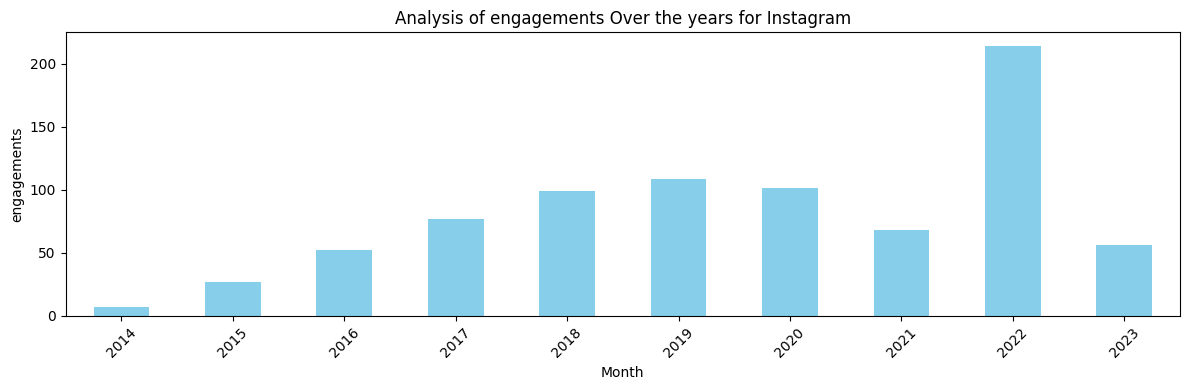

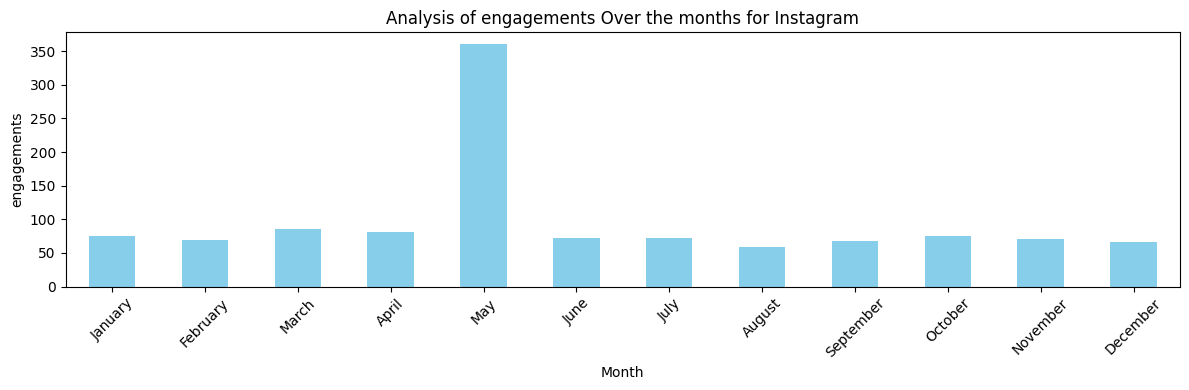

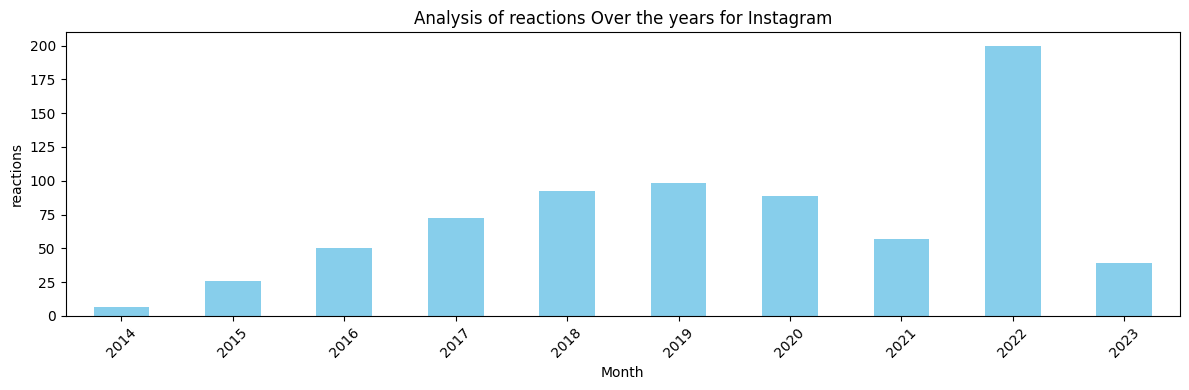

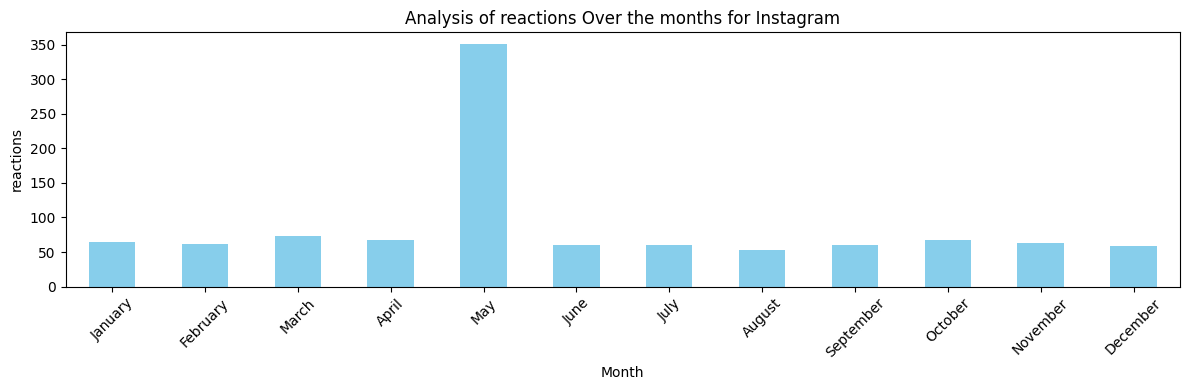

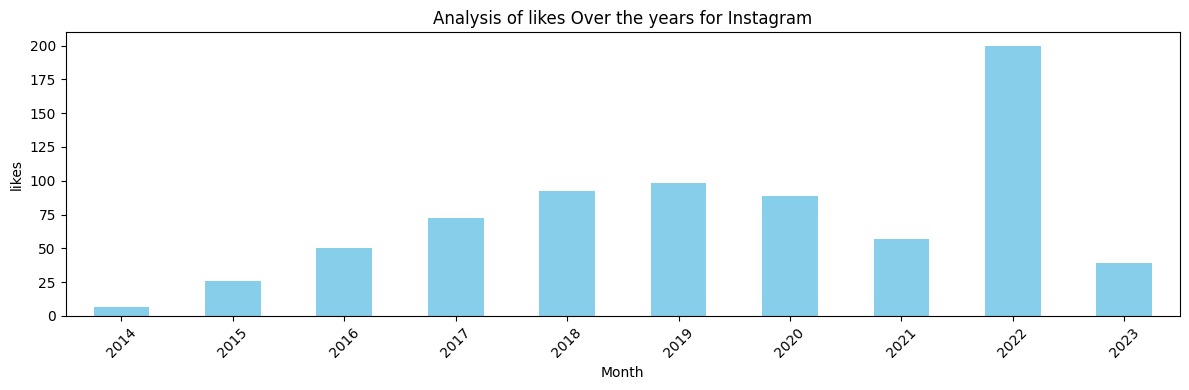

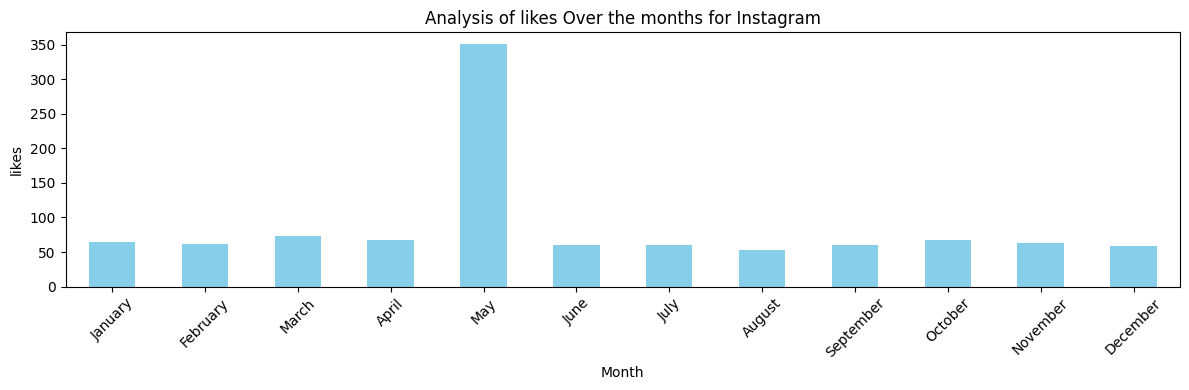

In [147]:

data_dir = "../data/interim/"
report_dir = "../reports/figures/"

platforms = ["Facebook", "Instagram", "LinkedIn", "Twitter"]

for platform in platforms:
    file_path = os.path.join(data_dir, f"{platform}_cleaned.csv")
    if not os.path.exists(file_path):
        continue
    
    df = pd.read_csv(file_path)
    
    numeric_summary = df.describe().to_dict()
    missing_values = df.isnull().sum().to_dict()
    numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
    
    for col in numeric_columns:
        if col == 'date':
            continue
        
        unique_values = df[col].unique()
        if 'date' in df.columns and len(unique_values) > 1 and unique_values[0] != 0:
            df['date'] = pd.to_datetime(df['date'])
            year = df.groupby(df['date'].dt.year)[col].mean()
            plt.figure(figsize=(12, 4))
            year.plot(kind='bar', color='skyblue', title=f'Analysis of {col} Over the years for {platform}')
            plt.xlabel('Month')
            plt.ylabel(col)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(report_dir, f'Analysis of {col} over the years {platform}.png'))
            plt.show()
            
            month = df.groupby(df['date'].dt.month)[col].mean()
            month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
            month.index = month.index.map(lambda x: month_names[x - 1])
            plt.figure(figsize=(12, 4))
            month.plot(kind='bar', color='skyblue', title=f'Analysis of {col} Over the months for {platform}')
            plt.xlabel('Month')
            plt.ylabel(col)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(report_dir, f'Analysis of {col} over months {platform}.png'))
            plt.show()

# QUESTIONS TO ANSWER

### 1. What are the most engaging types of posts?

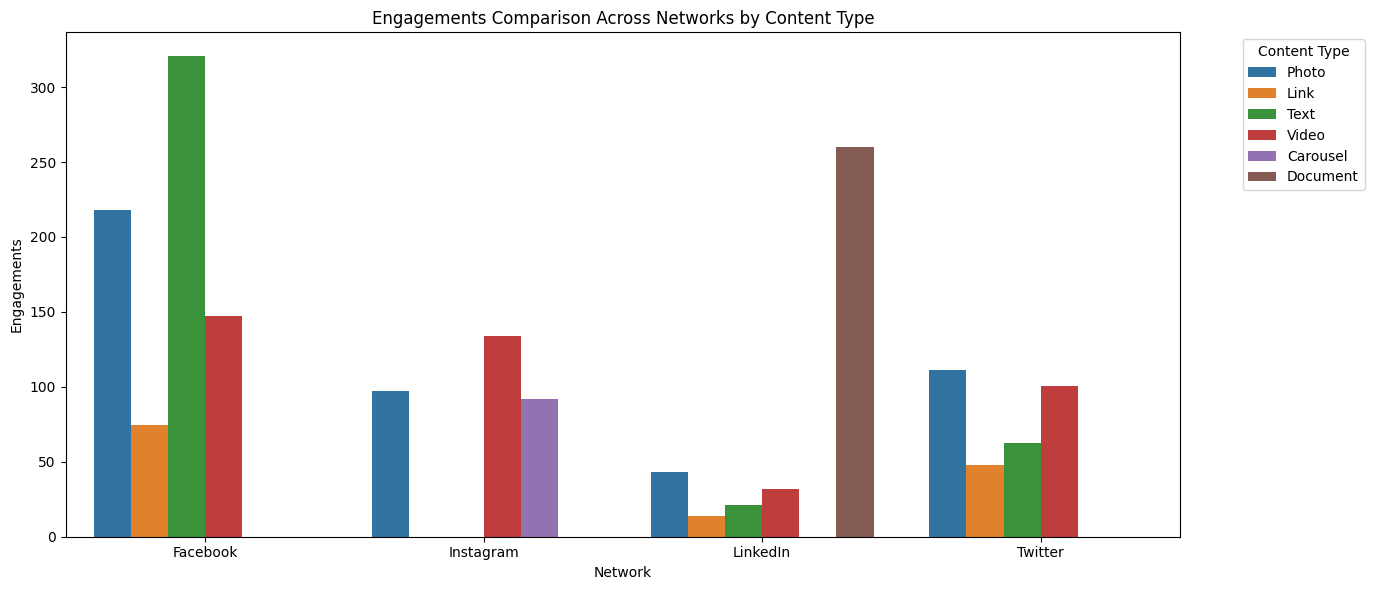

In [148]:
impressions_df = pd.DataFrame()
engagements_df = pd.DataFrame()

data = {}

# Load the datasets into the dictionary
for platform in platforms:
    file_path = os.path.join(data_dir, f"{platform}_cleaned.csv")
    if not os.path.exists(file_path):
        continue

    # Load the cleaned dataset
    data[platform] = pd.read_csv(file_path)

    # Merge the data into the respective DataFrames
    engagements_df = pd.concat([engagements_df, data[platform][['network', 'content_type', 'engagements']]], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=engagements_df, x="network", y="engagements", hue="content_type", errorbar=None)
plt.title("Engagements Comparison Across Networks by Content Type")
plt.xlabel("Network")
plt.ylabel("Engagements")
plt.tight_layout()
plt.legend(title="Content Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f'../reports/figures/Engagements_Comparison_Across_Networks_by_Content_Type.png')
plt.show()


### 2. Which platform yields the highest engagement for the client?

In [149]:
total_engagements = {platform: platform_data['engagements'].sum() for platform, platform_data in data.items()}
platform_with_highest_engagement = max(total_engagements, key=total_engagements.get)
print(f"Platform with yields the highest engagement for the clients is {platform_with_highest_engagement} \n with patform Engagement of {total_engagements}")

Platform with yields the highest engagement for the clients is Facebook 
 with patform Engagement of {'Facebook': 2023664.0, 'Instagram': 1004085, 'LinkedIn': 314005.0, 'Twitter': 863198.0}


### 3. What are the peak times for user engagement?

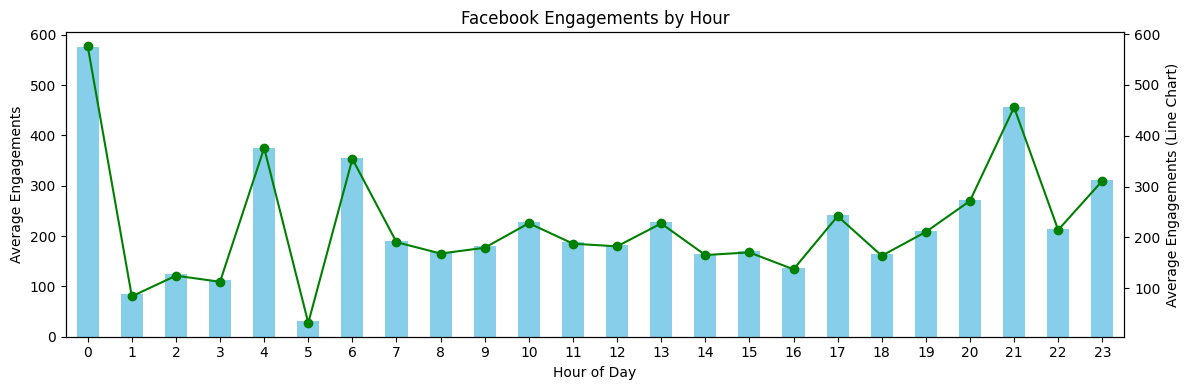

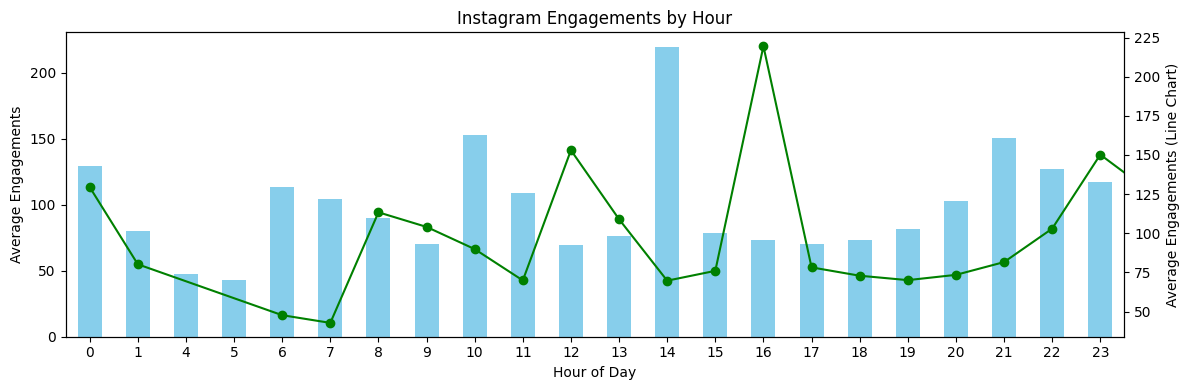

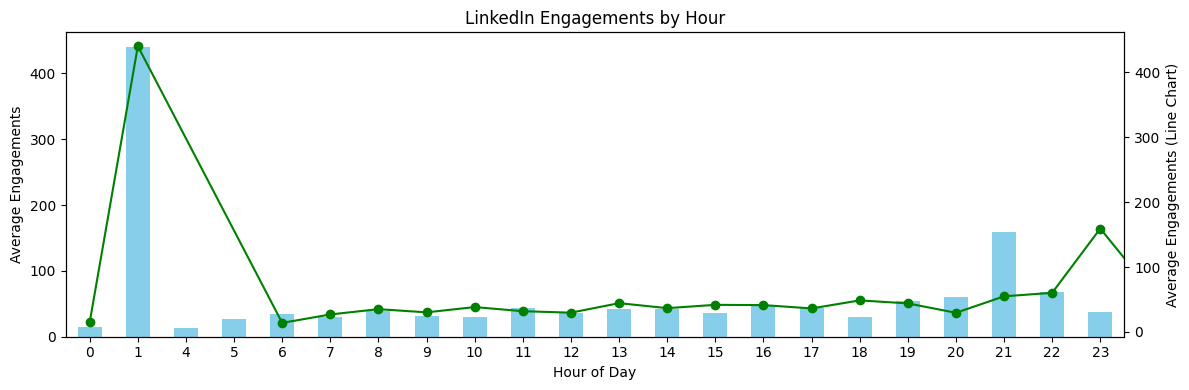

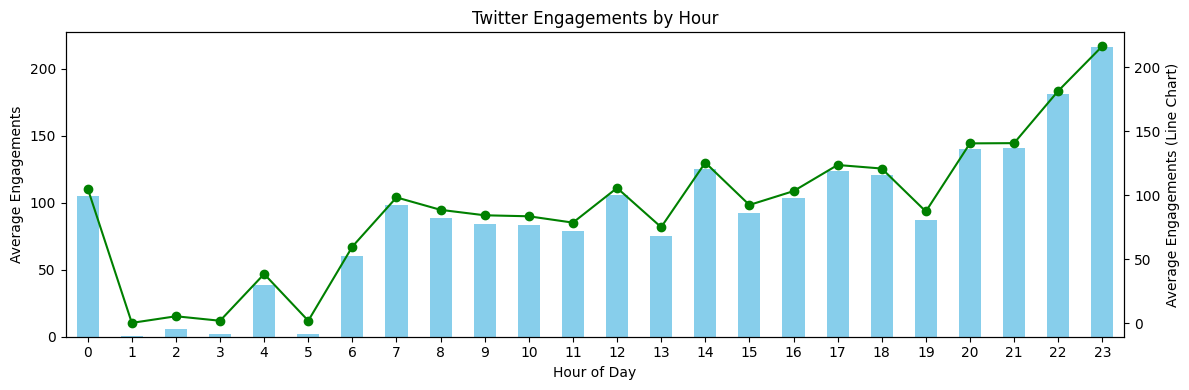

In [150]:
for platform in platforms:
    file_path = os.path.join(data_dir, f"{platform}_cleaned.csv")
    if not os.path.exists(file_path):
        continue
    
    platform_data = pd.read_csv(file_path)
    platform_data['date'] = pd.to_datetime(platform_data['date'])
    platform_data['hour'] = platform_data['date'].dt.hour
    
    engagements_by_hour = platform_data.groupby('hour')['engagements'].mean()
    
    # Create a figure with a shared X-axis
    fig, ax1 = plt.subplots(figsize=(12, 4))
    
    # Bar Chart
    engagements_by_hour.plot(kind='bar', ax=ax1, color='skyblue', title=f'{platform} Engagements by Hour')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Average Engagements')
    ax1.set_xticklabels(engagements_by_hour.index, rotation=0)
    
    # Create a secondary Y-axis for the line chart
    ax2 = ax1.twinx()
    
    # Line Chart
    engagements_by_hour.plot(kind='line', ax=ax2, marker='o', color='green')
    ax2.set_ylabel('Average Engagements (Line Chart)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(report_dir, f'{platform}_Engagements_by_Hour.png'))
    plt.show()

### 4. Are there any noticeable trends over time?

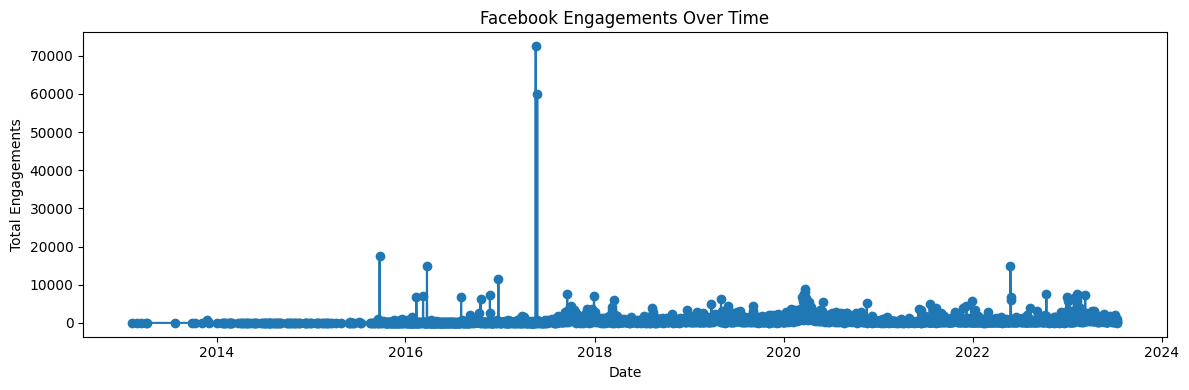

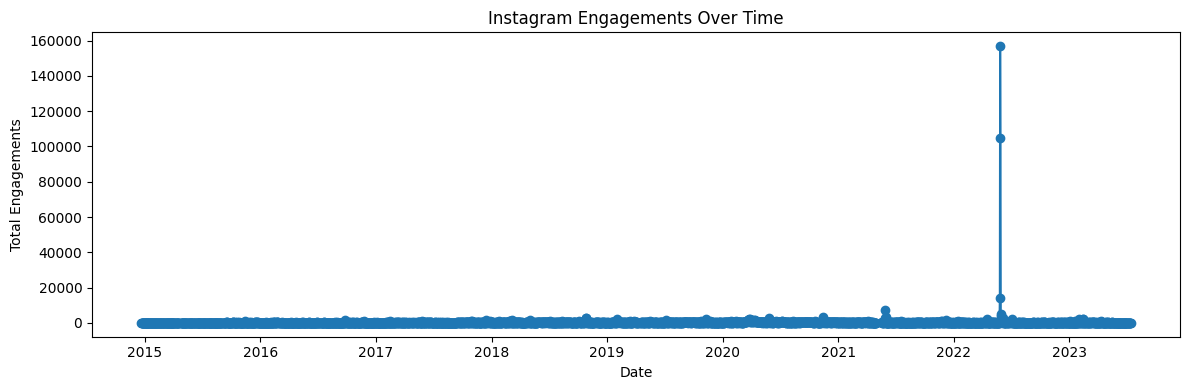

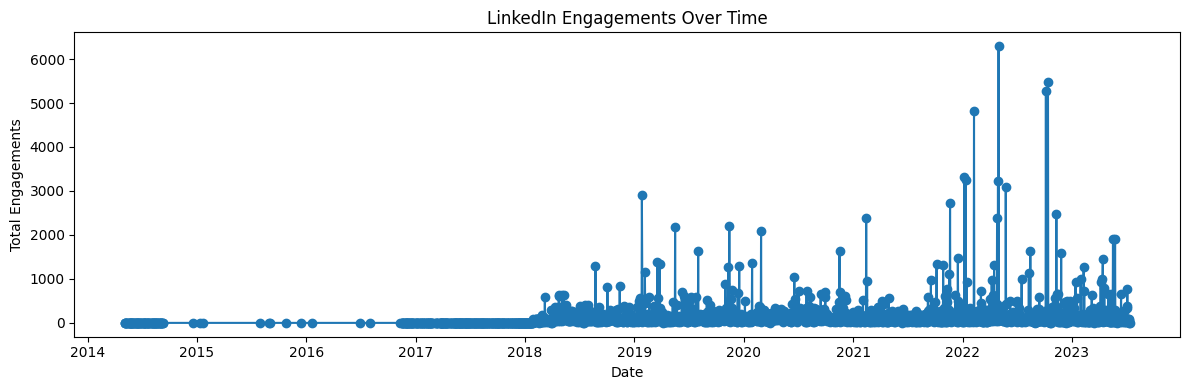

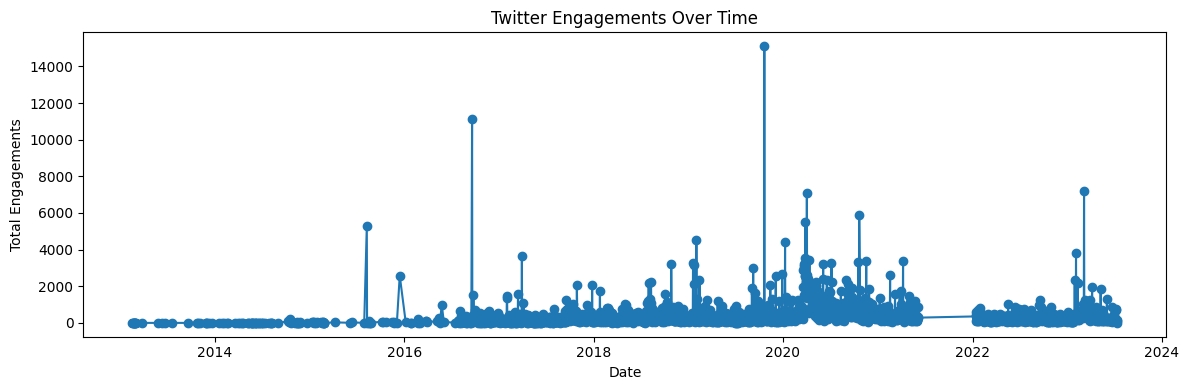

In [151]:
for platform, platform_data in data.items():
    platform_data['date'] = pd.to_datetime(platform_data['date'])
    daily_engagements = platform_data.groupby(platform_data['date'].dt.date)['engagements'].sum()

    plt.figure(figsize=(12, 4))
    daily_engagements.plot(kind='line', marker='o', title=f'{platform} Engagements Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Engagements')
    plt.tight_layout()
    plt.savefig(f'../reports/figures/{platform}_engagements_over_time.png')
    plt.show()

### Feature Engineering

In [152]:
def load_word_dictionary(file_path):
    try:
        with open(file_path, 'r') as json_file:
            return json.load(json_file)
    except (FileNotFoundError, json.JSONDecodeError):
        sep=1
    return {}

content_types_vocab = load_word_dictionary("../models/contenttypes.json")
network_vocab = load_word_dictionary("../models/network.json")

fixed_length = 40
print(content_types_vocab)

def convert_column_to_dict(dataframe, column_name, word_dict, sep=None):
    column_data = dataframe[column_name]
    words = [word for cell in column_data if pd.notna(cell) and cell.strip() for word in (cell.split(sep) if sep else cell.split())]
    
    # Assign unique sequential numeric values to the words
    unique_words = set(words)
    for word in unique_words:
        if word not in word_dict:
            word_dict[word.strip()] = len(word_dict)+1

# Save a dictionary as a JSON file
def save_dict_as_json(dictionary, file_name):
    with open(file_name, 'w') as json_file:
        json.dump(dictionary, json_file)


def map_words_to_integers(text, word_dict, sep=None):
    if isinstance(text, str):
        if sep is None:
            words = text.split()
        else:
            words = text.split(sep)
        return [word_dict.get(word.strip(), 0) for word in words]
    else:
        return []


def pad_or_truncate(lst):
    if len(lst) < fixed_length:
        return lst + [0] * (fixed_length - len(lst))
    else:
        return lst[:fixed_length]


{}


In [153]:


data = {}
cleaned_data_dir = "../data/processed"
for platform in platforms:
    file_path = os.path.join(data_dir, f"{platform}_cleaned.csv")
    if not os.path.exists(file_path):
        continue
    
    data[platform] = pd.read_csv(file_path)
    data[platform]['share_rate'] = data[platform]['shares'] / data[platform]['engagements']
    data[platform]['reaction_rate'] = data[platform]['reactions'] / data[platform]['engagements']



    data[platform] = data[platform].fillna(0) 
    data[platform] = data[platform].replace([float('inf'), -float('inf')], 0) 

    data[platform]['charcount']=data[platform]['post'].apply(len)
    convert_column_to_dict(data[platform],'network',network_vocab)
    print(network_vocab)
    convert_column_to_dict(data[platform],'content_type',content_types_vocab)
    print(content_types_vocab)
    data[platform]['content_type'] = data[platform]['content_type'].apply(lambda x: map_words_to_integers(x, content_types_vocab)[0])
    # print(data[platform]['content_type'])
    data[platform]['network'] = data[platform]['network'].apply(lambda x: map_words_to_integers(x, network_vocab)[0])
    # print(data[platform]['network'])
    
    cleaned_data_file = f"{platform}_processed.csv"
    cleaned_data_path = os.path.join(cleaned_data_dir, cleaned_data_file)
    
    data[platform]['duration'] = (datetime(2023, 9, 28, 12, 0) - pd.to_datetime(data[platform]['date'])).dt.total_seconds() / 60
    data[platform].drop('date', axis=1, inplace=True)
    data[platform].drop('post', axis=1, inplace=True)
    data[platform].drop('tags', axis=1, inplace=True)
    
    if os.path.exists(cleaned_data_path):
        data[platform].to_csv(cleaned_data_path, index=False, mode='w')
    else:
        data[platform].to_csv(cleaned_data_path, index=False)


save_dict_as_json(content_types_vocab, "../models/contenttypes.json")
save_dict_as_json(network_vocab, "../models/network.json")


{'Facebook': 1, 'Instagram': 2, 'LinkedIn': 3, 'Twitter': 4}
{'Photo': 1, 'Video': 2, 'Text': 3, 'Link': 4}
{'Facebook': 1, 'Instagram': 2, 'LinkedIn': 3, 'Twitter': 4}
{'Photo': 1, 'Video': 2, 'Text': 3, 'Link': 4, 'Carousel': 5}
{'Facebook': 1, 'Instagram': 2, 'LinkedIn': 3, 'Twitter': 4}
{'Photo': 1, 'Video': 2, 'Text': 3, 'Link': 4, 'Carousel': 5, 'Document': 6}
{'Facebook': 1, 'Instagram': 2, 'LinkedIn': 3, 'Twitter': 4}
{'Photo': 1, 'Video': 2, 'Text': 3, 'Link': 4, 'Carousel': 5, 'Document': 6}


# Train

In [154]:
combined_data = pd.DataFrame()

for platform in platforms:
    file_path = os.path.join(data_dir, f"{platform}_processed.csv")
    if not os.path.exists(file_path):
        continue
    
    data[platform] = pd.read_csv(file_path)
    
    # Concatenate the current platform's data to the combined_data DataFrame
    combined_data = pd.concat([combined_data, data[platform]], ignore_index=True)
    
X = combined_data[['content_type', 'network']]
print(X)
y = combined_data[['engagements', 'impressions', 'reactions', 'likes', 'engaged_users','subscribers',"shares"]]
t=y.dropna()

# Convert 'engaged_users' column to integers, handling errors by coercing non-numeric values to NaN.
y['engaged_users'] = pd.to_numeric(y['engaged_users'], errors='coerce')
y['subscribers'] = pd.to_numeric(y['subscribers'], errors='coerce')




       content_type  network
0                 0        0
1                 0        0
2                 0        0
3                 0        0
4                 0        0
...             ...      ...
35795             0        0
35796             0        0
35797             0        0
35798             0        0
35799             0        0

[35800 rows x 2 columns]


C:\Users\charl\AppData\Local\Temp\ipykernel_2040\2562896263.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['engaged_users'] = pd.to_numeric(y['engaged_users'], errors='coerce')
C:\Users\charl\AppData\Local\Temp\ipykernel_2040\2562896263.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['subscribers'] = pd.to_numeric(y['subscribers'], errors='coerce')


In [155]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Handle NaN values by filling with 0
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)
model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

model_save_path = f'../models/model.joblib'
joblib.dump(model, model_save_path)
print("saved")

saved


# TEST

In [156]:

model = joblib.load(f"../models/model.joblib")

new_post = pd.DataFrame({
    'content_type': [1], 
    'network': [1], 
})

# Make predictions using the loaded model
prediction = model.predict(new_post)
prediction=prediction[0]
predic={
    'engagements':prediction[0], 
    'impressions':prediction[1], 
    'reactions':prediction[2], 
    'likes':prediction[3], 
    'engaged_users':prediction[4],
    'subscribers':prediction[5],
    "shares":prediction[6]
}
print(predic)


{'engagements': 118.27574231843575, 'impressions': 2844.34699650838, 'reactions': 56.412874301675984, 'likes': 55.74280970670393, 'engaged_users': 28.974803770949723, 'subscribers': 25.043686452513967, 'shares': 4.118754888268156}
